In [1]:
import sys
sys.path.append('../')
import numpy
import pandas
import seaborn

from deepracer.tracks import TrackIO, Track

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu,\
    NewRewardUtils as nr \

from reward import AWSReward, RewardFactory
import reward.awsreward as rewards
from utils.loader import get_df, load_sample_complete_laps
from utils.transformer import df_to_params, new_names_df, get_episode
from utils.new_rewards import aggregate_episode_reward, summary
track = TrackIO(base_path='../tracks').load_track("reinvent_base")
fname = '../logs/training-simulation-logs-w7.log'

full_df= get_df(fname)
import warnings
warnings.filterwarnings('ignore')

Loaded 71 waypoints


In [30]:
class NewReward(AWSReward):
    max_speed    = 1.0
    
    def _calculateReward(self):
        return self.x + self.y

In [31]:
def plot_new_reward(df,reward_names):
    import seaborn

    new_df = df.loc[:,['duration','step'] + [f'cumulative_{n}' for n in reward_names] ]
    new_df = new_df.set_index('duration').sort_index()
    seaborn.lineplot(data=new_df,)

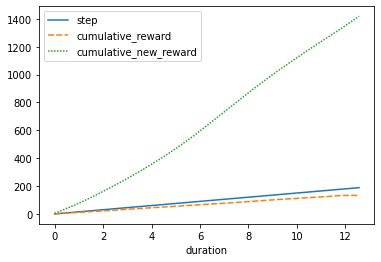

In [32]:
df = aggregate_episode_reward(get_episode(full_df,1),NewReward, df_to_params, track, 'new_reward')
plot_new_reward(df,['reward','new_reward'])

In [33]:
summary(df,['new_reward'])

,,step,closest_waypoint_index,progress,speed,time,reward,duration,new_reward
iteration,episode,,,,,,,,
1,1,189,4,48.9639,0.629365,00:00:12,133.469,12.568453,1418.5668


# Evaluate in new_reward in sample_complete_laps

In [34]:
sample_complete_laps_path = '../logs/sample_complete_laps.csv'
scl_df = load_sample_complete_laps(sample_complete_laps_path)

In [35]:
cum_scl = aggregate_episode_reward(scl_df,NewReward, df_to_params, track, 'new_reward')

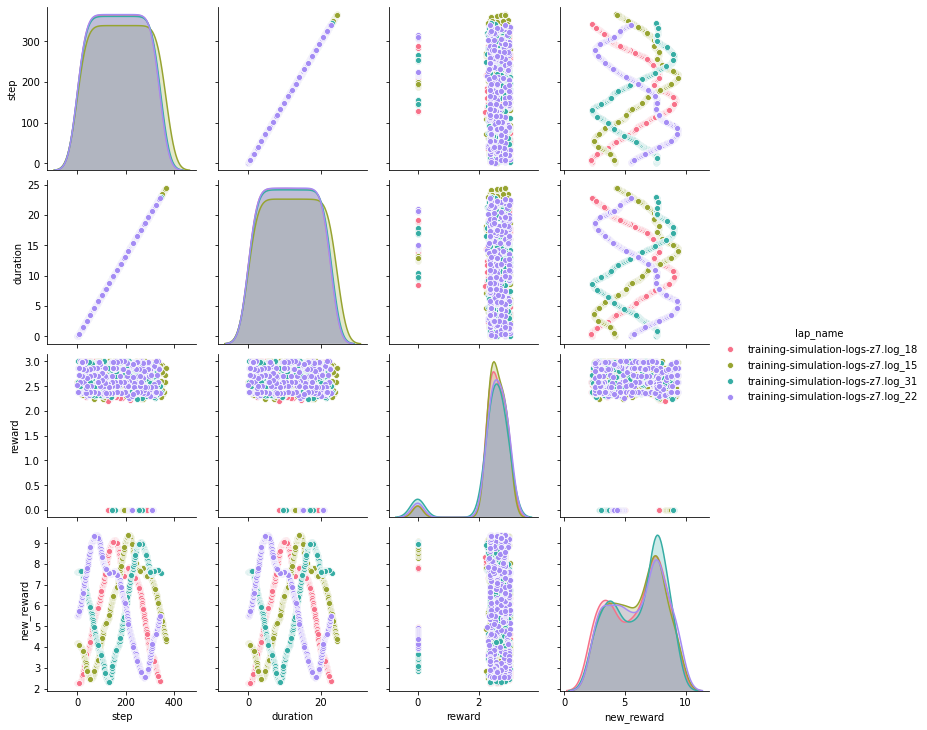

In [36]:
cols = ['step','duration','lap_name','reward','new_reward']
seaborn.pairplot(cum_scl[cols],hue='lap_name',palette="husl")
# cum_scl[cols]
# cum_scl.columns

In [ ]:
cols = ['stream','time','step','stream','speed','duration','reward','new_reward', 'lap_name']
aditional_map = {'lap_name': max}
summ_scl  = summary(cum_scl,['reward','new_reward'],use_stream=True,aditional_maps=aditional_map).reset_index()[cols]

In [ ]:
filtered_summ = pandas.concat( [ summ_scl.nlargest(5,'duration'),
                                summ_scl.nsmallest(5,'duration')
                               ])
filtered_summ

In [ ]:
seaborn.pairplot(filtered_summ,hue='lap_name')

In [ ]:
seaborn.pairplot(summ_scl,hue='lap_name')

In [ ]:
laps = ['training-simulation-logs-z6.log_30','training-simulation-logs-w5.log_39']
filtered_by_lap_summ = summ_scl[summ_scl.lap_name.isin(laps)]
filtered_by_lap_summ

In [ ]:
seaborn.pairplot(filtered_by_lap_summ,hue='lap_name')